![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite@3x.png)

# Havasu Geometry ETL Example

This notebook demonstrates working with Havasu, a spatial table format, using a taxi pickup dataset. [Read more about Havasu in the Wherobots documentation.](https://docs.wherobots.com/latest/references/havasu/introduction/)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col
from sedona.spark import *

# Define Sedona Context

In [2]:
config = SedonaContext.builder().appName('havasu-iceberg-geometry-etl')\
    .config("spark.hadoop.fs.s3a.bucket.wherobots-examples.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()
sedona = SedonaContext.create(config)

23/10/14 01:22:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/14 01:22:02 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/10/14 01:22:03 WARN S3ABlockOutputStream: Application invoked the Syncable API against stream writing to pvoaenkhn3/spark-logs/spark-0837386b8f514f0fbe684747f5188879.inprogress. This is unsupported
23/10/14 01:22:50 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/10/14 01:23:05 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
23/10/14 01:23:20 WARN TaskSche

# Load Taxi Pickup Records In WherobotsDB

In [3]:
taxidf = sedona.read.format('csv').option("header","true").option("delimiter", ",").load("s3://wherobots-examples/data/nyc-taxi-data.csv")
taxidf = taxidf.selectExpr('ST_Point(CAST(Start_Lon AS Decimal(24,20)), CAST(Start_Lat AS Decimal(24,20))) AS pickup', 'Trip_Pickup_DateTime', 'Payment_Type', 'Fare_Amt')
taxidf = taxidf.filter(col("pickup").isNotNull())
taxidf.show(5)
taxidf.createOrReplaceTempView('taxiDf')

+--------------------+--------------------+------------+--------+
|              pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+--------------------+--------------------+------------+--------+
|POINT (-73.991957...|         1/4/09 2:52|        CASH|     8.9|
|POINT (-73.982102...|         1/4/09 3:31|      Credit|    12.1|
|POINT (-74.002587...|        1/3/09 15:43|      Credit|    23.7|
|POINT (-73.974267...|        1/1/09 20:52|      CREDIT|    14.9|
|POINT (-74.00158 ...|       1/24/09 16:18|        CASH|     3.7|
+--------------------+--------------------+------------+--------+
only showing top 5 rows



# Manage taxi pickup data using Havasu

Havasu is a data lake for geospatial data. Users can manage their datasets as Havasu tables.

## Save DataFrame to a Havasu Table

In [4]:
sedona.sql("CREATE NAMESPACE IF NOT EXISTS wherobots.test_db")
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.taxi")
taxidf.writeTo("wherobots.test_db.taxi").create()

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


## Read taxi pickup records from Havasu Table

In [5]:
taxidf = sedona.table("wherobots.test_db.taxi")
taxidf.show(5)
print('total count: ' + str(taxidf.count()))

+--------------------+--------------------+------------+--------+
|              pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+--------------------+--------------------+------------+--------+
|POINT (-73.991957...|         1/4/09 2:52|        CASH|     8.9|
|POINT (-73.982102...|         1/4/09 3:31|      Credit|    12.1|
|POINT (-74.002587...|        1/3/09 15:43|      Credit|    23.7|
|POINT (-73.974267...|        1/1/09 20:52|      CREDIT|    14.9|
|POINT (-74.00158 ...|       1/24/09 16:18|        CASH|     3.7|
+--------------------+--------------------+------------+--------+
only showing top 5 rows

total count: 99998


### Note that the pickup column is a geometry column.

In [6]:
taxidf.printSchema()

root
 |-- pickup: geometry (nullable = true)
 |-- Trip_Pickup_DateTime: string (nullable = true)
 |-- Payment_Type: string (nullable = true)
 |-- Fare_Amt: string (nullable = true)



### Seamless integration with WherobotsDB functions

We can directly apply Sedona ST_ functions to pickup column.

In [7]:
taxidf.withColumn("buf", expr("ST_Buffer(pickup, 1e-4)")).show(5)

+--------------------+--------------------+------------+--------+--------------------+
|              pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|                 buf|
+--------------------+--------------------+------------+--------+--------------------+
|POINT (-73.991957...|         1/4/09 2:52|        CASH|     8.9|POLYGON ((-73.991...|
|POINT (-73.982102...|         1/4/09 3:31|      Credit|    12.1|POLYGON ((-73.982...|
|POINT (-74.002587...|        1/3/09 15:43|      Credit|    23.7|POLYGON ((-74.002...|
|POINT (-73.974267...|        1/1/09 20:52|      CREDIT|    14.9|POLYGON ((-73.974...|
|POINT (-74.00158 ...|       1/24/09 16:18|        CASH|     3.7|POLYGON ((-74.001...|
+--------------------+--------------------+------------+--------+--------------------+
only showing top 5 rows



## ACID Properties of Havasu Table

Havasu supports all ACID properties on a on-disk table, we can append data or modify the table.

In [8]:
bufdf = taxidf.withColumn("pickup", expr("ST_Buffer(pickup, 1e-4)"))
bufdf.writeTo("wherobots.test_db.taxi").append()
countAppend = sedona.table("wherobots.test_db.taxi").count()
print('total count after append: ' + str(countAppend))

total count after append: 199996


We can also use SQL to manipulate data

In [9]:
sedona.sql("SELECT * FROM wherobots.test_db.taxi").show(5)

+--------------------+--------------------+------------+--------+
|              pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+--------------------+--------------------+------------+--------+
|POINT (-73.991957...|         1/4/09 2:52|        CASH|     8.9|
|POINT (-73.982102...|         1/4/09 3:31|      Credit|    12.1|
|POINT (-74.002587...|        1/3/09 15:43|      Credit|    23.7|
|POINT (-73.974267...|        1/1/09 20:52|      CREDIT|    14.9|
|POINT (-74.00158 ...|       1/24/09 16:18|        CASH|     3.7|
+--------------------+--------------------+------------+--------+
only showing top 5 rows



In [10]:
sedona.sql("INSERT INTO wherobots.test_db.taxi VALUES (ST_Point(10, 20), '1/26/09 10:20', 'Cash', 3.14)")
sedona.sql("INSERT INTO wherobots.test_db.taxi VALUES (ST_Point(10, 20), '1/26/09 10:20', 'Online', 31.4)")
sedona.sql("SELECT * FROM wherobots.test_db.taxi WHERE ST_Intersects(pickup, ST_Point(10, 20))").show()

+-------------+--------------------+------------+--------+
|       pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+-------------+--------------------+------------+--------+
|POINT (10 20)|       1/26/09 10:20|      Online|    31.4|
|POINT (10 20)|       1/26/09 10:20|        Cash|    3.14|
+-------------+--------------------+------------+--------+



In [11]:
sedona.sql("UPDATE wherobots.test_db.taxi SET Fare_Amt = 314 WHERE ST_Intersects(pickup, ST_Point(10, 20)) AND Payment_Type = 'Online'")
sedona.sql("SELECT * FROM wherobots.test_db.taxi WHERE ST_Intersects(pickup, ST_Point(10, 20))").show()

+-------------+--------------------+------------+--------+
|       pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+-------------+--------------------+------------+--------+
|POINT (10 20)|       1/26/09 10:20|        Cash|    3.14|
|POINT (10 20)|       1/26/09 10:20|      Online|     314|
+-------------+--------------------+------------+--------+



In [12]:
sedona.sql("DELETE FROM wherobots.test_db.taxi WHERE Payment_Type = 'Online'")
sedona.sql("SELECT * FROM wherobots.test_db.taxi WHERE ST_Intersects(pickup, ST_Point(10, 20))").show()

+-------------+--------------------+------------+--------+
|       pickup|Trip_Pickup_DateTime|Payment_Type|Fare_Amt|
+-------------+--------------------+------------+--------+
|POINT (10 20)|       1/26/09 10:20|        Cash|    3.14|
+-------------+--------------------+------------+--------+



## Time Travel

We can view table history and read a particular version of the table.

In [13]:
sedona.sql("SELECT * FROM wherobots.test_db.taxi.history ORDER BY made_current_at").show()

+--------------------+-------------------+-------------------+-------------------+
|     made_current_at|        snapshot_id|          parent_id|is_current_ancestor|
+--------------------+-------------------+-------------------+-------------------+
|2023-10-14 01:24:...|7461884413075999179|               null|               true|
|2023-10-14 01:24:...| 457349553059563397|7461884413075999179|               true|
|2023-10-14 01:24:...|2579162651400776349| 457349553059563397|               true|
|2023-10-14 01:24:...|5290276924018748163|2579162651400776349|               true|
|2023-10-14 01:24:...|6247404520564280571|5290276924018748163|               true|
|2023-10-14 01:24:...|6226879153158247575|6247404520564280571|               true|
+--------------------+-------------------+-------------------+-------------------+



In [14]:
snapshots = sedona.sql("SELECT * FROM wherobots.test_db.taxi.history ORDER BY made_current_at").collect()
snapshot_1 = snapshots[1]['snapshot_id']

In [15]:
sedona.table("wherobots.test_db.taxi").count()

199997

In [16]:
sedona.read.option("snapshot-id", snapshot_1).table("wherobots.test_db.taxi").count()

199996

In [17]:
sedona.sql("SELECT * FROM wherobots.test_db.taxi VERSION AS OF {}".format(snapshot_1)).count()

199996

Now let's roll back to version 1

In [18]:
sedona.sql("CALL wherobots.system.rollback_to_snapshot('wherobots.test_db.taxi', {})".format(snapshot_1))
sedona.sql("SELECT * FROM wherobots.test_db.taxi").count()

23/10/14 01:24:50 WARN BaseTransaction: Failed to load metadata for a committed snapshot, skipping clean-up


199996

## Optimize table for faster range query

We run a small range query on the dataset to see how many records we've scanned

In [19]:
predicate = "ST_Intersects(ST_PolygonFromEnvelope(-73.970730, 40.767844, -73.965615, 40.769217), pickup)"
taxidf = sedona.table("wherobots.test_db.taxi")
taxidf.where(predicate).count()

345

We can inspect the metrics data and found that Spark scanned all the data to answer this query

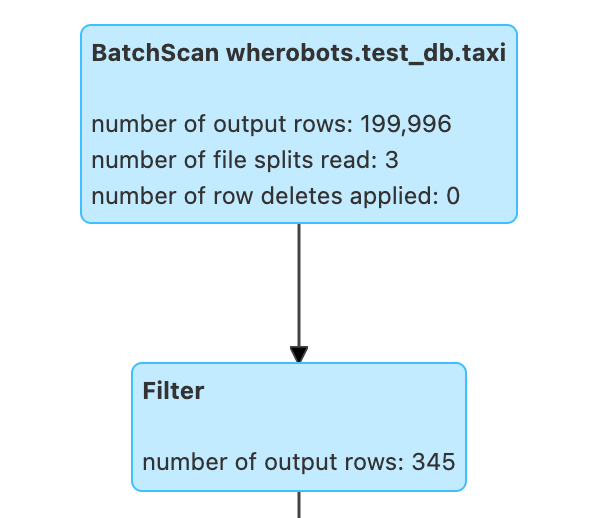

### CREATE SPATIAL INDEX

We can run `CREATE SPATIAL INDEX` on the table to sort the records by spatial proximity. Havasu supports sorting the geometry values by their Hilbert index.

In [20]:
sedona.sql("CREATE SPATIAL INDEX FOR wherobots.test_db.taxi USING hilbert(pickup, 16) OPTIONS map('target-file-count', '30')").show()

+--------------------------+----------------------+---------------------+-----------------------+
|rewritten_data_files_count|added_data_files_count|rewritten_bytes_count|failed_data_files_count|
+--------------------------+----------------------+---------------------+-----------------------+
|                         3|                    46|             27602931|                      0|
+--------------------------+----------------------+---------------------+-----------------------+



In [21]:
taxidf = sedona.table("wherobots.test_db.taxi")
taxidf.where(predicate).count()

345

The same query scanned less data, this is because the spatial filter pushdown works better on sorted tables.

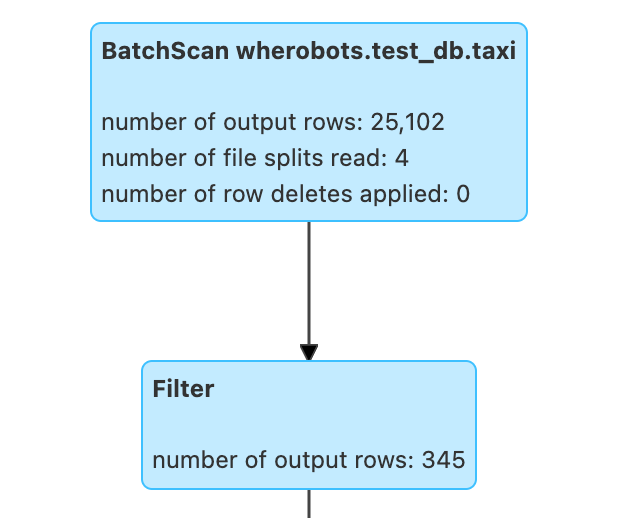

### Sorting by geohash value

We can sort the pickup column by their geohash values and write them into 30 files.

In [22]:
sedona.sql("DROP TABLE IF EXISTS wherobots.test_db.taxi_sorted")
sortedTaxiDf = taxidf.withColumn("geohash", expr("ST_GeoHash(ST_Centroid(pickup), 20)"))\
    .sort(col("geohash"))\
    .drop("geohash")
sortedTaxiDf.write.option("target-file-size-bytes", "1000000").format("havasu.iceberg").saveAsTable("wherobots.test_db.taxi_sorted")

We run the same query on the sorted table, the result is identical with running on the original table.

In [23]:
sortedTaxiDf = sedona.table("wherobots.test_db.taxi_sorted")
sortedTaxiDf.where(predicate).count()

345

The same query scanned less data, this is because the spatial filter pushdown works better on sorted tables.

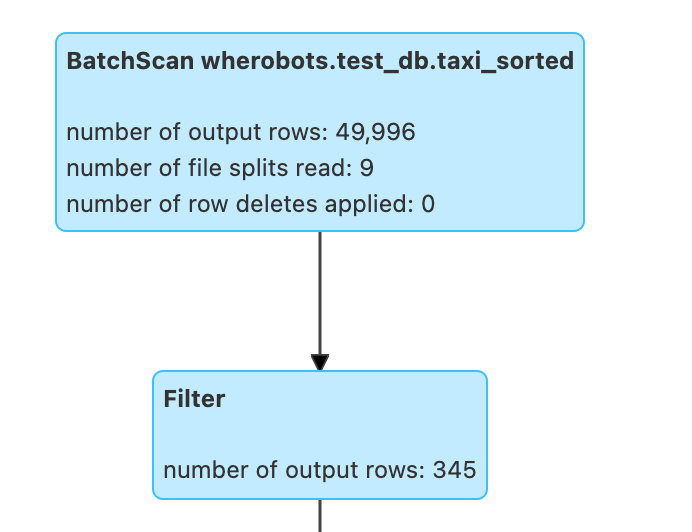